In [1]:
# set jupyter notebook width to full
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# you may need to install these:

# !pip install wget
# !pip install scikit-image

In [3]:
# Show working directory.  
# If 14cat.zip is not in this folder it will be fetched from www
%pwd

'C:\\Users\\rb\\Desktop\\submit'

In [4]:
# set target size for image resizing (224 pixels x 224 pixels)
target_size  = (224, 224)

# set input shape (224 pixels x 224 pixels x 3 channels)
input_shape  = (224, 224, 3)

# set mini-batch size for image data generator
batch_size   = 32

# set epoch count for training
epoch_count  = 80

# make category list
cats = ['Elbow Abnormal', 'Elbow Normal', 'Finger Abnormal', 'Finger Normal', 'Forearm Abnormal', 'Forearm Normal', 'Hand Abnormal', 'Hand Normal', 'Humerus Abnormal', 'Humerus Normal', 'Shoulder Abnormal', 'Shoulder Normal', 'Wrist Abnormal', 'Wrist Normal']

# set up folders
ospath = %pwd
PathToFiles  = ospath + '\\14cat' 
train_path = PathToFiles + '\\train'
valid_path = PathToFiles + '\\valid'

# verify paths
print(PathToFiles)
print(train_path)
print(valid_path)

C:\Users\rb\Desktop\submit\14cat
C:\Users\rb\Desktop\submit\14cat\train
C:\Users\rb\Desktop\submit\14cat\valid


In [5]:
# the dataset for this project is 3.2GB.  It is available in its original form from Stanford Univeristy 
#  here:  https://stanfordmlgroup.github.io/competitions/mura/

import wget
import os.path
from os import path
from zipfile import ZipFile

# if path.exists(ospath + '\\14cat.zip'):
#     print('Zip file exists.')
# else:
#     print('Downloading zip file...')
#     url = 'https://www.mediafire.com/file/9qvieovqkwnw205/14cat.zip/file'
#     filename = wget.download(url)
#     print('Complete.')

# if path.exists(ospath + '\\14cat\\valid\\Wrist Normal\\XR_WRIST-patient11391-study1_negative-image3.png'):
#     print('Image files exist.')
# else:
#     file_name = "14cat.zip"
#     # open the zip file for reading
#     with ZipFile(file_name, 'r') as zip:
#         # extract files
#         print('Image files do not exist.')
#         print('Extracting all the images now...this might take a few minutes depending on your system...')
#         zip.extractall()
#         print('Done!')

100% [....................................................................] 3374492974 / 3374492974Complete.
Image files do not exist.
Extracting all the images now...this might take a few minutes depending on your system...
Done!


In [6]:
import tensorflow as tf
from tensorflow import keras

# show versions
print('Tensorflow version: ', tf.__version__)
print('Keras version     : ', keras.__version__)

# GPU SETUP (YOU MAY NEED TO SKIP THIS) 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.list_physical_devices()

Tensorflow version:  2.5.0-dev20201123
Keras version     :  2.5.0
Num GPUs Available:  1


In [7]:
# imports
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from skimage import transform
from numpy import array
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l1
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [8]:
# define plot function for accuracy metrics
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(history.epoch, np.array(history.history['accuracy']), label='Training Accuracy')
    plt.plot(history.epoch, np.array(history.history['val_accuracy']), label = 'Validation Accuracy')
    plt.legend()
    plt.ylim([0, 1])

In [9]:
# define predict function

def predict():
    # randomly choose a bodypart from the validation set
    validation_category = random.choice([x for x in os.listdir(valid_path)]) # if os.path.isfile(os.path.join(valid_path, x))])
    
    # randomly choose an image from the bodypart in the validation set 
    validation_image = random.choice([x for x in os.listdir((valid_path + '\\' + validation_category))])

    # set image path
    image_path = valid_path + '\\' + validation_category + '\\' + validation_image

    # open, normalize, resize, and make rank 4 array because we used rank 4 mini-batches to train
    image_array = Image.open(image_path)
    image_array = np.array(image_array).astype('float32')/255
    image_array = transform.resize(image_array, (224, 224, 3))
    image_array = np.expand_dims(image_array, axis=0)

    # make actual prediction
    result = model.predict(image_array)

    # translate prediction to category
    cat_index = np.argmax(result)

    # determine correctness
    if validation_category == cats[cat_index]:
        isCorrect = 'CORRECT'
    else:
        isCorrect = 'INCORRECT'
    
    # print some output
    print('Actual Category   : ', validation_category)
    print('Predicted Category: ', cats[cat_index])
    print('                    ', isCorrect)
    plt.imshow(mpimg.imread(image_path))
    plt.show()

    # return nothing
    return 

In [10]:
# set up datagenerator for training data.  Normalize and use augmentation.
train_datagen = ImageDataGenerator(
    rescale = 1.0 / 255.0,     
    rotation_range = 90,
    horizontal_flip = True) 

# set up datagenerator for validation data.  Normalize only, no augmentation.
valid_datagen = ImageDataGenerator(
    rescale = 1.0 / 255.0)

# set up training flow from directory, target image size, batch size, and 'categorical'
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = "categorical",
    seed = 123)

# set up validation flow from directory, target image size, batch size, and 'categorical'
valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = "categorical",
    seed = 123)

Found 36806 images belonging to 14 classes.
Found 3197 images belonging to 14 classes.


In [11]:
# create model.  MobileNetV2 performance exceeds any of our own models.
model = Sequential()
    
# Do not include the MobileNetV2 input layer, use the imagenet weights, set the input shape and set average pooling.
model.add(MobileNetV2(include_top = False, weights = 'imagenet', input_shape = input_shape, pooling = 'avg'))
# Add a fully connected layer with one neuron for each category (14)
model.add(Dense(14))
# activate sigmoid (between 0 and 1).  The predicted category will have the highest value of the 14 outputs (np.argmax)
model.add(Activation('sigmoid'))

# compile the model using categorical crossentropy, ADAM, and set metrics
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# show model summary
model.summary()

# set file name for saving models
filepath = 'BAN693-Project-v21.epoch{epoch:02d}-valacc{val_accuracy:.2f}.h5'

# set up checkpoint operation to save all epoch weights/models
checkpoint = ModelCheckpoint(filepath = filepath, 
                             monitor = 'val_accuracy',
                             verbose = 0, 
                             save_best_only = True,
                             mode = 'max',
                             save_weights_only = False)

callbacks = [checkpoint]



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 14)                17934     
_________________________________________________________________
activation (Activation)      (None, 14)                0         
Total params: 2,275,918
Trainable params: 2,241,806
Non-trainable params: 34,112
_________________________________________________________________


In [12]:
# fit the model
history = model.fit(train_generator, epochs = epoch_count, validation_data = valid_generator, callbacks = callbacks)

Epoch 1/80
1151/1151 [==============================] - 368s 315ms/step - loss: 1.0148 - accuracy: 0.6075 - val_loss: 4.3420 - val_accuracy: 0.3228
Epoch 2/80
1151/1151 [==============================] - 363s 316ms/step - loss: 0.6835 - accuracy: 0.7198 - val_loss: 2.7397 - val_accuracy: 0.4073
Epoch 3/80
1151/1151 [==============================] - 355s 308ms/step - loss: 0.6291 - accuracy: 0.7412 - val_loss: 3.5927 - val_accuracy: 0.3682
Epoch 4/80
1151/1151 [==============================] - 353s 307ms/step - loss: 0.6193 - accuracy: 0.7505 - val_loss: 1.5142 - val_accuracy: 0.5414
Epoch 5/80
1151/1151 [==============================] - 354s 307ms/step - loss: 0.6000 - accuracy: 0.7578 - val_loss: 1.9633 - val_accuracy: 0.4636
Epoch 6/80
1151/1151 [==============================] - 357s 310ms/step - loss: 0.5732 - accuracy: 0.7702 - val_loss: 1.3530 - val_accuracy: 0.6062
Epoch 7/80
1151/1151 [==============================] - 358s 311ms/step - loss: 0.5590 - accuracy: 0.7774 - val_

1151/1151 [==============================] - 352s 306ms/step - loss: 0.3109 - accuracy: 0.8736 - val_loss: 1.2983 - val_accuracy: 0.6384
Epoch 57/80
1151/1151 [==============================] - 352s 305ms/step - loss: 0.3051 - accuracy: 0.8745 - val_loss: 0.8388 - val_accuracy: 0.7254
Epoch 58/80
1151/1151 [==============================] - 352s 306ms/step - loss: 0.2977 - accuracy: 0.8766 - val_loss: 1.0682 - val_accuracy: 0.6763
Epoch 59/80
1151/1151 [==============================] - 352s 305ms/step - loss: 0.2970 - accuracy: 0.8795 - val_loss: 0.8595 - val_accuracy: 0.7219
Epoch 60/80
1151/1151 [==============================] - 352s 305ms/step - loss: 0.2914 - accuracy: 0.8801 - val_loss: 1.4489 - val_accuracy: 0.6184
Epoch 61/80
1151/1151 [==============================] - 352s 306ms/step - loss: 0.2967 - accuracy: 0.8789 - val_loss: 2.0093 - val_accuracy: 0.5130
Epoch 62/80
1151/1151 [==============================] - 351s 305ms/step - loss: 0.2816 - accuracy: 0.8843 - val_loss:

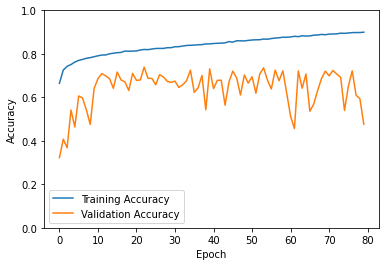

In [13]:
# plot accuracy metrics
plot_history(history)

Actual Category   :  Forearm Abnormal
Predicted Category:  Forearm Abnormal
                     CORRECT


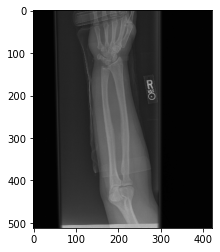

In [16]:
# make a prediction
predict()

In [ ]:
#############################################
# this is the end if you started at the top #
#############################################

In [14]:
############################################################
############################################################
# if you only want to make predictions, start at this cell #
#                                                          # 
# you must have the files already in place. you can run    #
#  the earlier cell that copies files if you need them.    #
############################################################
############################################################

cats = ['Elbow Abnormal', 'Elbow Normal', 'Finger Abnormal', 'Finger Normal', 'Forearm Abnormal', 'Forearm Normal', 'Hand Abnormal', 'Hand Normal', 'Humerus Abnormal', 'Humerus Normal', 'Shoulder Abnormal', 'Shoulder Normal', 'Wrist Abnormal', 'Wrist Normal']
path = %pwd
PathToFiles  = path + '\\14cat'
train_path = PathToFiles + '\\train'
valid_path = PathToFiles + '\\valid'
import tensorflow as tf
from tensorflow import keras
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.list_physical_devices()
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from skimage import transform
from numpy import array
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def predictmany(count):
    
    correct = 0
    images = []
    
    for x in range(count):
        # randomly choose a bodypart from the validation set
        validation_category = random.choice([x for x in os.listdir(valid_path)]) 

        # randomly choose an image from the bodypart in the validation set 
        validation_image = random.choice([x for x in os.listdir((valid_path + '\\' + validation_category))])

        # set image path
        images.append([valid_path + '\\' + validation_category + '\\' + validation_image, validation_category])
        
    # here we have images list with [path_to_image, category]

    result = []
    for image_path, category in images:
        
        # normalize, resize, and make rank 4 array because we used rank 4 mini-batches to train
        image_array = Image.open(image_path)
        image_array = np.array(image_array).astype('float32')/255
        image_array = transform.resize(image_array, (224, 224, 3))
        image_array = np.expand_dims(image_array, axis=0)

        # make actual prediction
        tempresult = [model.predict(image_array)]

        # translate prediction to category
        cat_index = np.argmax(tempresult)

        # add to list
        result.append([image_path, category, cats[cat_index]])
                      
    for ipath, actual, prediction in result:
        if actual == prediction:
            correct += 1

    print(correct, ' correct out of 10')
    print('\n\n\n\n\n')
        
    for ipath, actual, prediction in result:
        
        if actual == prediction:
            isCorrect = 'Correct'
        else:
            isCorrect = 'Not Correct'
                      
        print('Actual Category   : ', actual)
        print('Predicted Category: ', prediction)
        print('                    ', isCorrect)
        plt.imshow(mpimg.imread(ipath))
        plt.show()
        print('\n\n\n\n\n\n\n\n\n\n')        
        print('\n\n\n\n\n\n\n\n\n\n') 
        
    return 



In [15]:
model = keras.models.load_model("savedmodel.h5")

7  correct out of 10






Actual Category   :  Finger Normal
Predicted Category:  Finger Normal
                     Correct


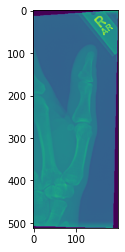























Actual Category   :  Humerus Normal
Predicted Category:  Humerus Normal
                     Correct


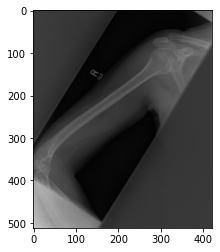























Actual Category   :  Elbow Abnormal
Predicted Category:  Elbow Abnormal
                     Correct


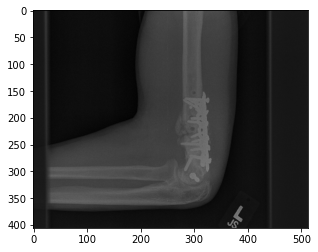























Actual Category   :  Finger Normal
Predicted Category:  Finger Normal
                     Correct


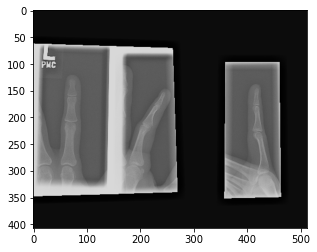























Actual Category   :  Hand Abnormal
Predicted Category:  Hand Normal
                     Not Correct


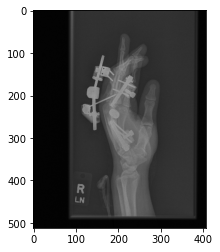























Actual Category   :  Elbow Normal
Predicted Category:  Elbow Normal
                     Correct


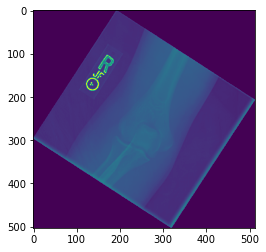























Actual Category   :  Elbow Abnormal
Predicted Category:  Elbow Normal
                     Not Correct


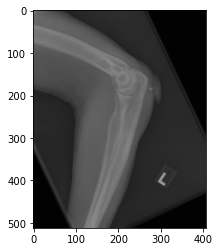























Actual Category   :  Elbow Normal
Predicted Category:  Elbow Normal
                     Correct


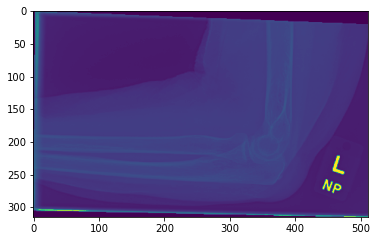























Actual Category   :  Finger Abnormal
Predicted Category:  Finger Normal
                     Not Correct


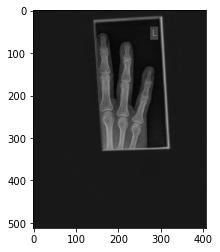























Actual Category   :  Forearm Abnormal
Predicted Category:  Forearm Abnormal
                     Correct


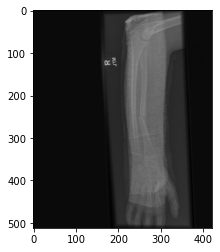

In [19]:
predictmany(10)